## Chapter 22 - Nominal Predicted Variable

- [22.3.3.1 - Softmax model](#22.3.3.1---Softmax-model)
- [22.3.3.2 - Conditional logistic model](#22.3.3.2---Conditional-logistic-model)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import mode, beta
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
#%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

### 22.3.3.1 - Softmax model

#### Data

In [2]:
# Using dtype 'category' for Y
df = pd.read_csv('data/SoftmaxRegData1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.0 KB


In [3]:
df.head()

         X1        X2  Y
0 -0.087147 -1.081342  2
1 -0.722566 -1.583863  1
2  0.179190  0.971790  3
3 -1.159752  0.502624  3
4 -0.727118  1.375704  3

In [4]:
# Standardize the data
X = df[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

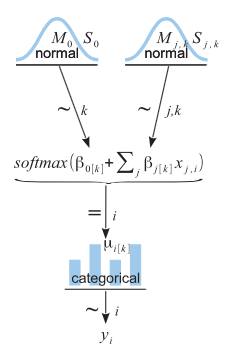

In [5]:
Image('images/fig22_4.png')

In [6]:
# Number of categories
n_cat = df.Y.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pmc.Model() as model_softmax:
    # priors for categories 2-4, excluding reference category 1 which is set to zero below.
    zbeta0_ = pmc.Normal('zbeta0_', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta_ = pmc.Normal('zbeta_', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    # add prior values zero (intercept, predictors) for reference category 1.
    zbeta0 = pmc.Deterministic('zbeta0', tt.concatenate([[0], zbeta0_]))
    zbeta = pmc.Deterministic('zbeta', tt.concatenate([tt.zeros((2, 1)), zbeta_], axis=1))

    mu = zbeta0 + pmc.dot(zX, zbeta)
    
    # Theano softmax function
    p = pmc.Deterministic('p', tt.nnet.softmax(mu))
    
    y = pmc.Categorical('y', p=p, observed=df.Y.cat.codes.as_matrix())

In [7]:
with model_softmax:
    step = pmc.Metropolis()
    trace1 = pmc.sample(50000, step)

 [-----------------100%-----------------] 50000 of 50000 complete in 27.2 sec

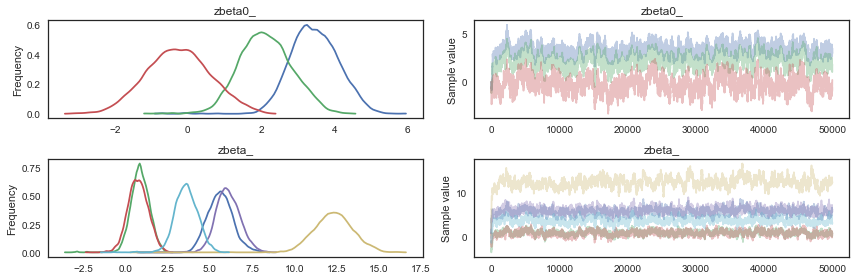

In [8]:
# Traceplot, excluding the parameters for the reference category (which are zero)
pmc.traceplot(trace1, ['zbeta0_', 'zbeta_']);

In [9]:
# Transform parameters back to original scale
zbeta0 = trace1['zbeta0']
zbeta = trace1['zbeta']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat,1))/np.tile(scalex, (n_cat,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat,1)).T)

print(beta0.shape)
print(beta.shape)

(50000, 4)
(50000, 2, 4)


In [10]:
# Join the two multi-dimensional arrays
estimates = np.insert(beta, 0, beta0, axis=1)
estimates.shape

(50000, 3, 4)

#### Figure 22.5

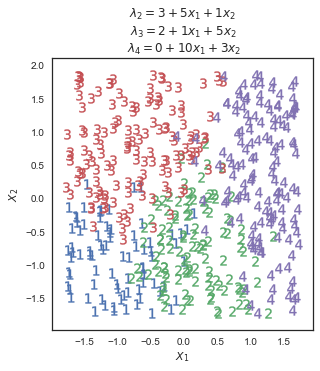

In [11]:
plt.figure(figsize=(5,5))
for outcome in df.Y.cat.categories:
    plt.scatter(df[df.Y == outcome].X1, df[df.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_2 = 3+5x_1+1x_2$ \n $\lambda_3 = 2+1x_1+5x_2$ \n $\lambda_4 = 0+10x_1+3x_2$')
plt.gca().set_aspect('equal')

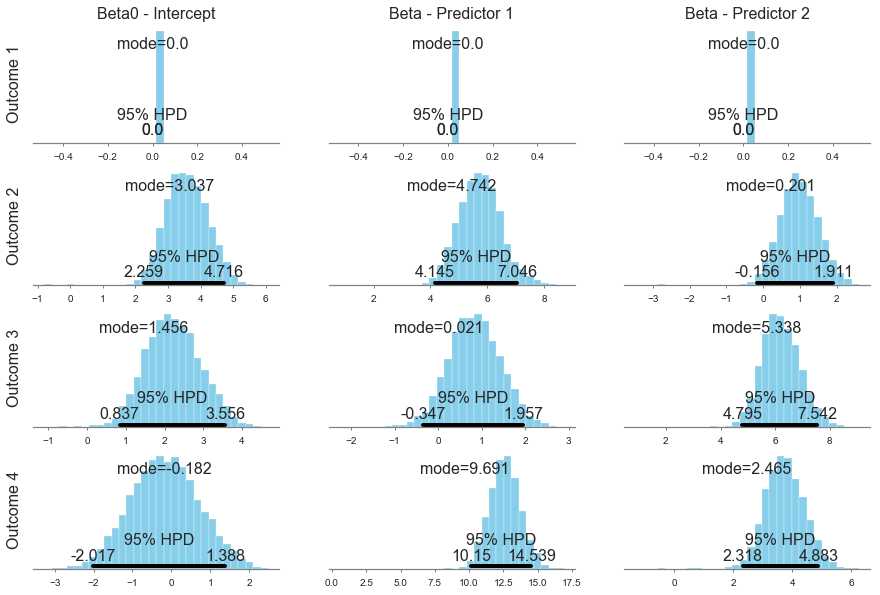

In [12]:
fig, axes = plt.subplots(4,3, figsize=(15,10));
# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    pmc.plot_posterior(estimates[:,c,r], point_estimate='mode', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Outcome {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

### 22.3.3.2 - Conditional logistic model

#### Data

In [13]:
df = pd.read_csv('data/CondLogistRegData1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.0 KB


In [14]:
df.head()

         X1        X2  Y
0 -0.087147 -1.081342  2
1 -0.722566 -1.583863  1
2  0.179190  0.971790  3
3 -1.159752  0.502624  1
4 -0.727118  1.375704  3

In [15]:
# Standardize the data
X = df[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

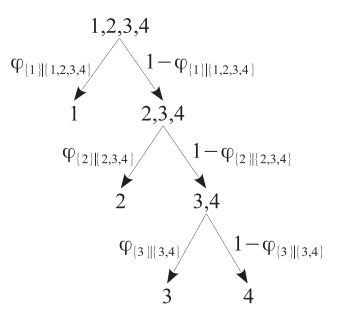

In [16]:
Image('images/fig22_2L.png')

In [17]:
# Number of categories
n_cat = df.Y.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pmc.Model() as model_cond_log:
    # priors
    zbeta0 = pmc.Normal('zbeta0', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta = pmc.Normal('zbeta', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    phi = pmc.invlogit(zbeta0 + pmc.dot(zX, zbeta))
  
    mu0 = phi[:,0]
    mu1 = phi[:,1] * (1-phi[:,0])
    mu2 = phi[:,2] * (1-phi[:,1]) * (1-phi[:,0])
    mu3 = (1-phi[:,2]) * (1-phi[:,1]) * (1-phi[:,0])
    mu = pmc.stack([mu0, mu1, mu2, mu3], axis=1)
    
    y = pmc.Categorical('y', p=mu, observed=df.Y.cat.codes.as_matrix())

In [18]:
with model_cond_log:
    step = pmc.Metropolis()
    trace2 = pmc.sample(50000, step)

 [-----------------100%-----------------] 50000 of 50000 complete in 26.3 sec

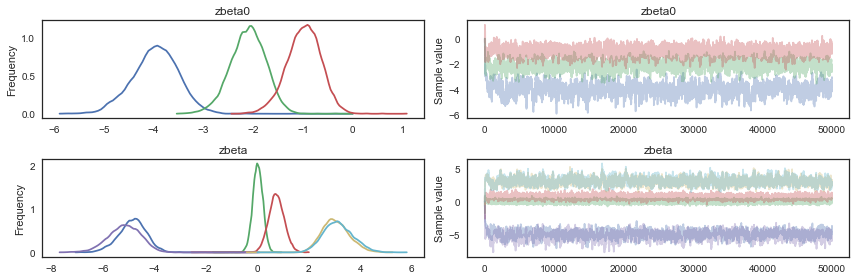

In [19]:
pmc.traceplot(trace2);

In [20]:
# Transform parameters back to original scale
zbeta0 = trace2['zbeta0']
zbeta = trace2['zbeta']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat-1,1))/np.tile(scalex, (n_cat-1,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat-1,1)).T)

print(beta0.shape)
print(beta.shape)

(50000, 3)
(50000, 2, 3)


In [21]:
# Join the two multi-dimensional arrays
estimates = np.insert(beta, 0, beta0, axis=1)
estimates.shape

(50000, 3, 3)

#### Figure 22.6

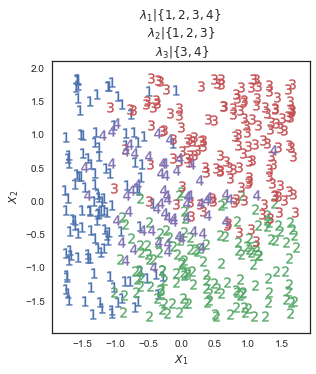

In [22]:
plt.figure(figsize=(5,5))
for outcome in df.Y.cat.categories:
    plt.scatter(df[df.Y == outcome].X1, df[df.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_{1}|\{1,2,3,4\}$ \n $\lambda_{2}|\{1,2,3\}$ \n $\lambda_{3}|\{3,4\}$')
plt.gca().set_aspect('equal')

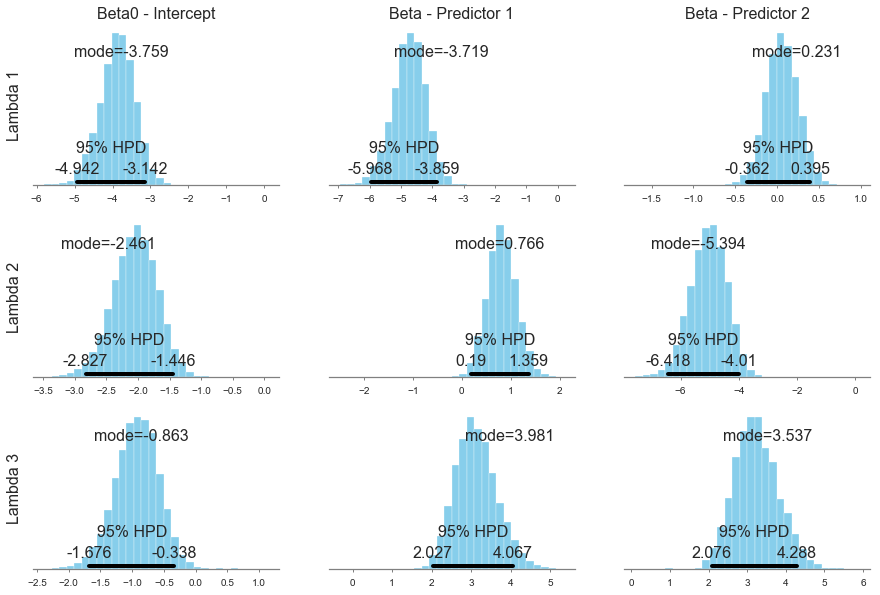

In [23]:
fig, axes = plt.subplots(3,3, figsize=(15,10));
# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    pmc.plot_posterior(estimates[:,c,r], point_estimate='mode', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Lambda {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

#### Model (Kruschke, 2015)

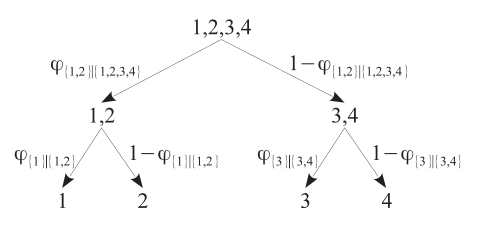

In [24]:
Image('images/fig22_2R.png')